# Using FEM to solve scattering problem

## Problem description

$$
\begin{aligned}
&\Delta u + k(x)^2 u = 0 &\text{for } x \in \Gamma \\
&(\nabla_n-ik_0)(u-u_0) = 0           &\text{for } x \in \partial \Gamma
\end{aligned}
$$

where $\Gamma$ is a spherical domain and $k=k_0$ at $\partial\Gamma$

## Step 1. Setup geometry

In [1]:
from geom import ball, box
outter = ball(6,.3)
inner = box([.5,.5,1],.2).move([0,1,0]) + box([.5,.5,1],.2).move([0,-1,0])
# inner = ball(1, .3)
geom = outter - inner
# geom = outter
geom.eps = .1

## Step 2. Setup mesh

In [2]:
from mesh import Mesh
import numpy as np
# quality = lambda ps: .5 * (np.linalg.norm(ps,axis=-1)-1) / 5 + .3
quality = .4
mesh = Mesh(10000, quality, geom)

# mesh.refine(.005,N_tot=2,N_sub=200)

In [3]:
mesh.refine(.01,N_tot=5,N_sub=100)

step	substep	max dis
4	80	0.24853330063658918


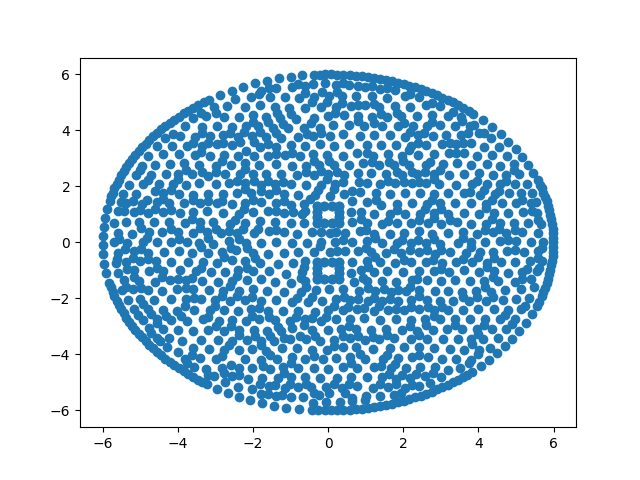

In [4]:
%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np
# points = mesh.points[list(set(mesh.get_simplices().ravel()))]
# points = mesh.points[outter.points.shape[0]:outter.points.shape[0]+inner.points.shape[0]]
points = mesh.points
plt.figure()
plt.scatter(*points[abs(points[:,2])<.2][:,[0,1]].T)

## Step 3. Setup FEM matrices

In [5]:
from FEM import FEM
fem = FEM(mesh)

In [6]:
np.isfinite(fem.nabla.data).all()

True

## Step 4. Setup source, boundary and everything else

In [7]:
mask = np.ones(mesh.points.shape[0], bool)
mask[len(outter.points):mesh.fixed.stop] = False

In [8]:
from numpy.linalg import norm
from numpy import exp
k = 4
xs = mesh.points
n = norm(xs,axis=-1)
# gauss = lambda center,sig: exp(-np.sum((xs-center)**2,axis=-1)/sig**2)
# k2 = (gauss([0,1,0],2)+gauss([0,-1,0],2)+1)*k**2
x = mesh.points[:,0]
cos = mesh.points[:,0] / n
# src = 1j * k * (x/n-1) * exp(1j*x*k)
# b = fem.bound @ src
# L = fem.nabla - fem.diag(k2) - 1j*k*fem.bound
L = fem.nabla - k*k*fem.inner - 1j*k*fem.bound

u0 = exp(1j*x*k)
u0[mask] = 0
b = -L@u0 

b = b[mask]
L = L[mask][:,mask]

## Step 5. Solve with BICGSTAB

In [9]:
from scipy.sparse.linalg import bicgstab
for step in range(5):
    u,conv = bicgstab(L,b,tol=1e-3,maxiter=1000)
    print(f"step {step} conv={conv}")
    if conv==0:
        break
else:
    raise Exception("BICGSTAB not converged")

step 0 conv=0


## Final Step: Visualize

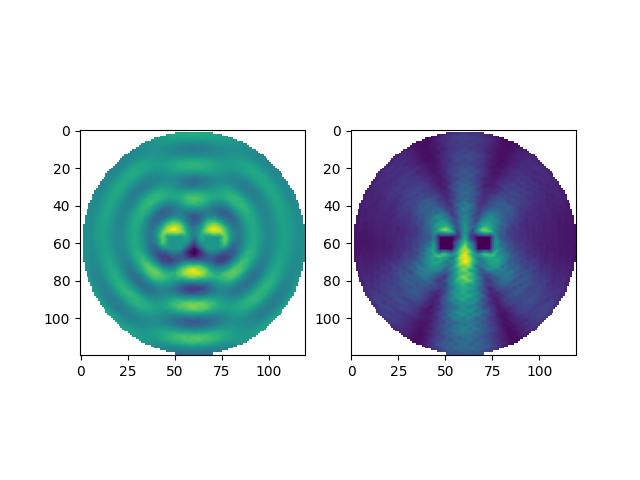

In [13]:
from scipy.interpolate import LinearNDInterpolator
from numpy import mgrid
u_all = np.zeros(mesh.points.shape[0],complex)
u_all[mask] = u
# u_all[:] = u
u_interp = LinearNDInterpolator(mesh.tri, u_all)
x,y = mgrid[-6:6:.1,-6:6:.1]
res = u_interp(x,y,0)
# res = np.where(x*x+y*y<1,np.nan,res)
inp = exp(1j*k*x)
inp[x*x+y*y<=1.1] = 0
fig,(a,b) = plt.subplots(1,2)
a.imshow(res.real)
b.imshow(abs(res))